# Najlepsze metody oceny modelu i strojenie parametryczne


In [1]:
from IPython.display import Image

## Wstęp 

W tym rozdziale poruszono następujące tematy:
- uzyskiwanie uczciwych oszacowań skuteczności modelu
- diagnozowanie najcześtszych problemów w alg. uczenia maszynowego
- strojenie modeli
- ocenianie modeli predykcyjnych za pomocą różnych metryk skuteczności

## Usprawnienie cyklu pracy za pomocą kolejkowania 

Korzystanie z klasy _pipeline_ która służy do kolejkowania, doboru dowolnej liczby etapów transforamcji danych

## Wczytanie zestawu danych Breast Cancer Wisconsin 

In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Pierwsze 2 kolumny, unikalny identyfikator cech oraz rozpoznanie (M- złośliwy, B łagodny)

In [3]:
#zakodowanie klas
from sklearn.preprocessing import LabelEncoder
X= df.loc[:,2:].values
y= df.loc[:,1].values
le= LabelEncoder()
y= le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [4]:
#podział na testowe i uczące
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Łączenie funkcji transformujących i estymatorów w kolejce czynności 

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Dokładność testu: %.3f' % pipe_lr.score(X_test, y_test))

Dokładność testu: 0.947


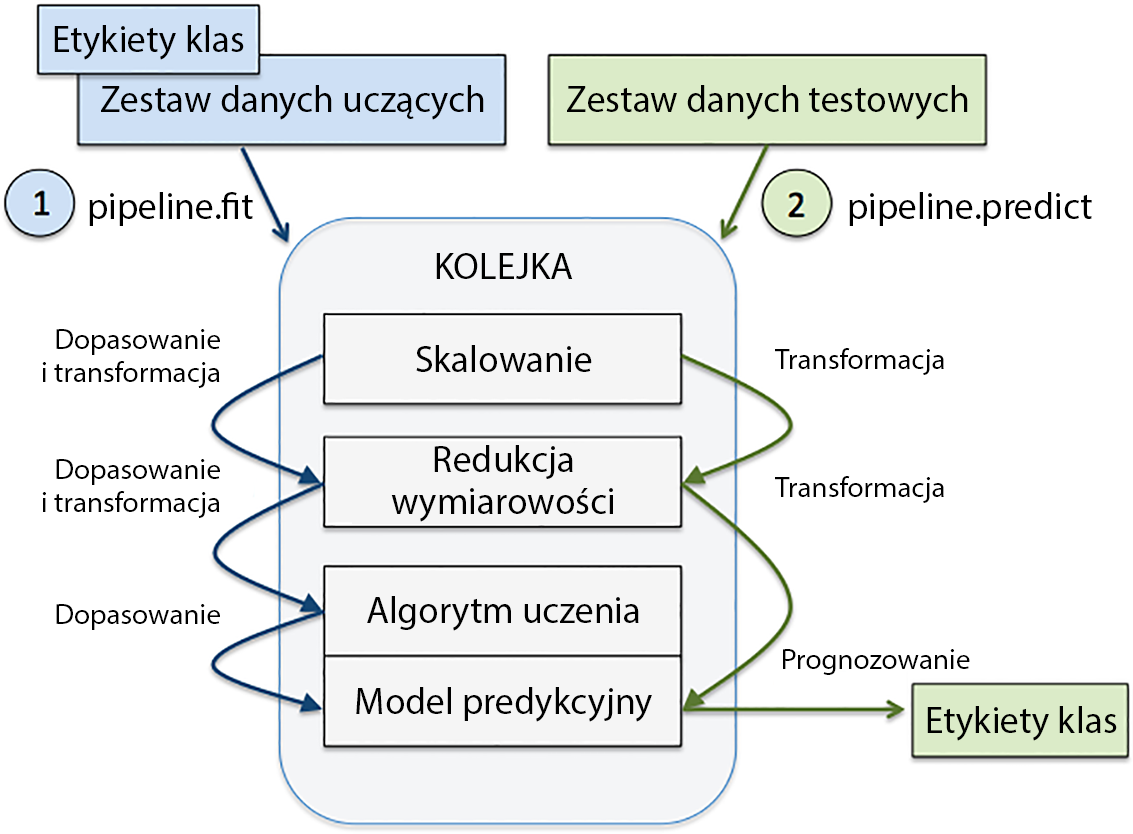

In [6]:
Image(filename='./rysunki/rozdzial 6/06_01.png', width=500) 

##  Stosowanie k-krotnego sprawdzianu krzyżowego w ocenie skuteczności modelu

__Przypomnienie__ model może być niewystarczająco dopasowany (duże obciążenie) z powodu zbyt małej złożoności lub przetrenowany (wysoka wariancja)  z powodu zbyt wysokiego skomplikowania. A więc oceniamy model za pomocą technik: metody wydzielenia i k-krotnej kroswalidacji.

## Metoda wydzielenia (holdout cross-validation)

- Ważne pojęcia jak dobór modelu i hiperparametry.
- Stąd dzielimy model na zbiór uczący walidacyjny i testowy. 
- Skuteczność sprawdzana zbiorem waliadacyjnym
- schemat na rysunku poniżej
- wada: czułość oszacowania skuteczności na sposób podziału danych

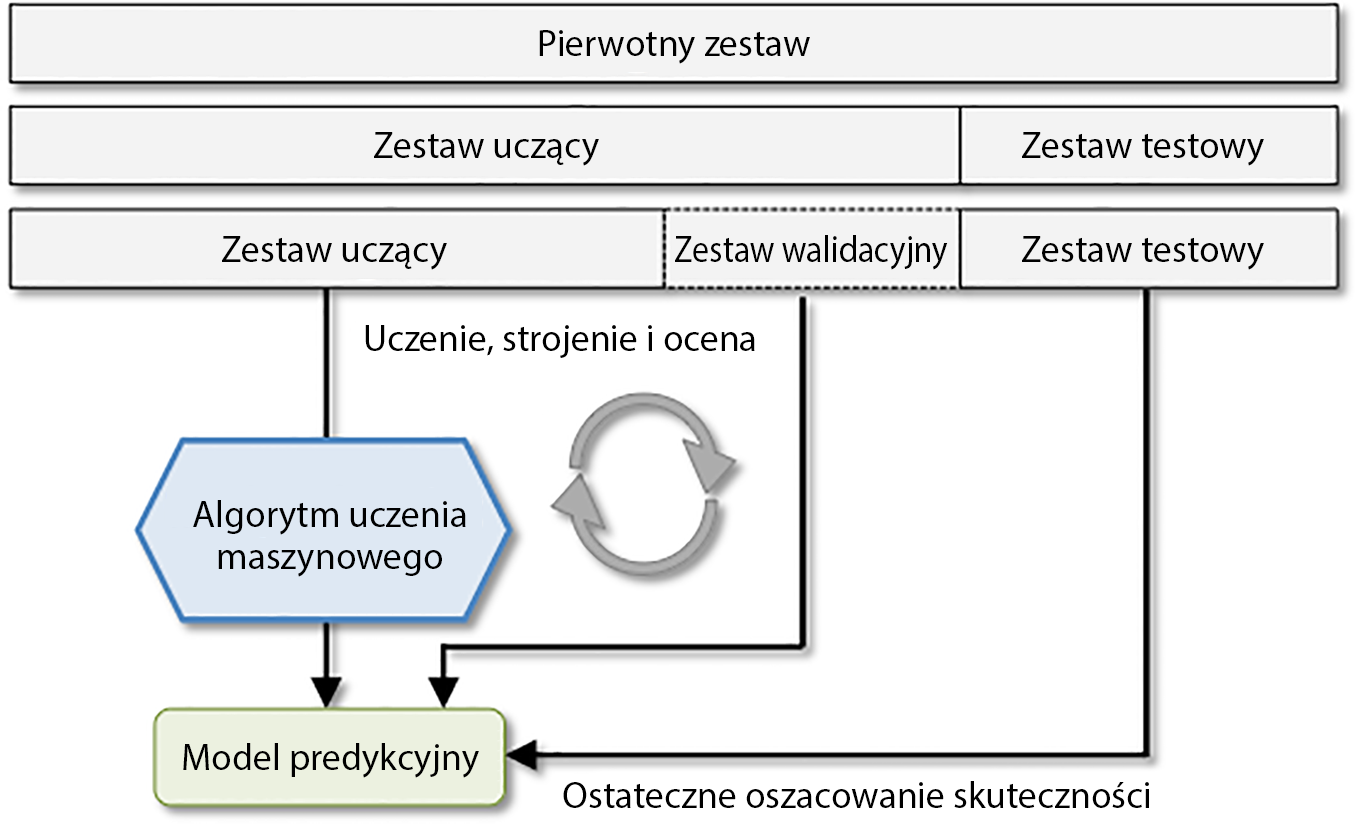

In [7]:
Image(filename='./rysunki/rozdzial 6/06_02.png', width=500)

## K-krotny sprawdzian krzyżowy (k-fold cross-validation) 

- losowo rozdzielamy zestaw danych uczących na k niezastępowanych podzbiorów, gdzie k-1 podzbiorów jest wykorzystywanych do uczenia a 1 do testowania. Proces jest powtarzany k-krotnie (otrzymujemy k-modeli i oszacowań). Następnie obliczamy średnią  skuteczności modeli (mniejsza wrażliwość na podział danych).
- jest to technika próbkowania bez zwracania
- rysunek poniżej pokazuje przykład dla k=10 

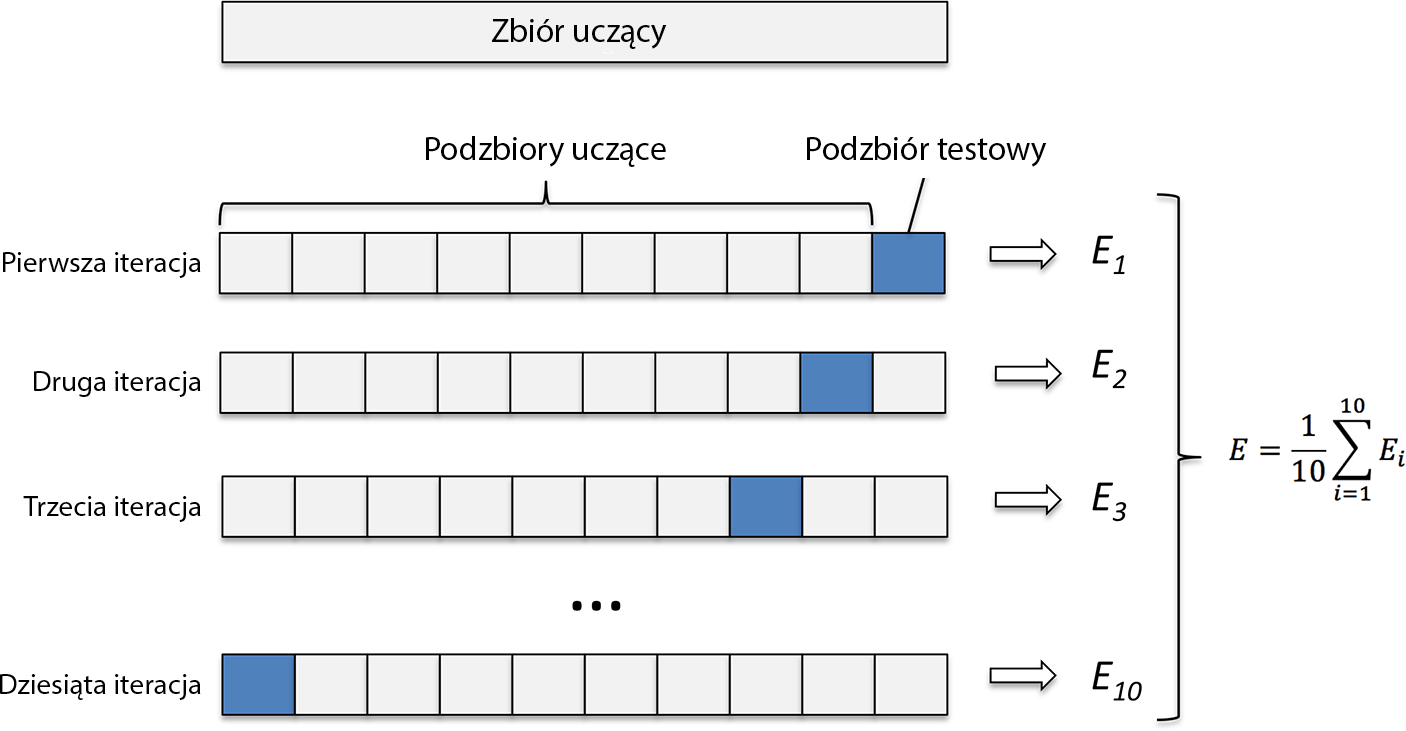

In [8]:
Image(filename='./rysunki/rozdzial 6/06_03.png',width=700)

- standardowo k wynosi 10
- mały zestaw danych, wieksza liczba podzbiorów
- większe k-> mniejsze obciążenie modelu wczasie oszacowania wydajności uogólnania
- ale też zwiększony czas pracy algorytmu i obarczenie osacowania większą wariancją. 
- przy dużych zbiorach może być mniejsze k
- modyfikacja > warstwowy k-krotny sprawdzian krzyżowy, który lepiej radzi sobie z oszacowaniem obciązenia i wariancji
- w stratyfikowanej walidacji krzyżowej proporcje pomiędzy klasami zostają zachowane w każym podzbiorze, dzięki czemu poszczególne podzbiory reprezentują proprocje klas w zestawue uczącym


In [9]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold= StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)
scores=[]
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score= pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Podzbiór: %s, Rozdział klasy: %s, Dokładność %.3f' %(k+1, np.bincount(y_train[train]),score))
    

Podzbiór: 1, Rozdział klasy: [256 153], Dokładność 0.891
Podzbiór: 2, Rozdział klasy: [256 153], Dokładność 0.978
Podzbiór: 3, Rozdział klasy: [256 153], Dokładność 0.978
Podzbiór: 4, Rozdział klasy: [256 153], Dokładność 0.913
Podzbiór: 5, Rozdział klasy: [256 153], Dokładność 0.935
Podzbiór: 6, Rozdział klasy: [257 153], Dokładność 0.978
Podzbiór: 7, Rozdział klasy: [257 153], Dokładność 0.933
Podzbiór: 8, Rozdział klasy: [257 153], Dokładność 0.956
Podzbiór: 9, Rozdział klasy: [257 153], Dokładność 0.978
Podzbiór: 10, Rozdział klasy: [257 153], Dokładność 0.956


In [10]:
print('Dokładność sprawdzianu: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Dokładność sprawdzianu: 0.950 +/- 0.029


Biblioteka scikit pozwala na skuteczne ocenienianie naszego modelu przy użyciu wartstowej kroswalidacji


In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('Wyniki dokładności sprawdzianu %s'  %scores)

Wyniki dokładności sprawdzianu [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]


In [12]:
print('Dokładność sprawdzianu: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Dokładność sprawdzianu: 0.950 +/- 0.029


## Sprawdzenie algorytmów za pomocą krzywych uczenia i krzywch walidacji 

__Przypomnienie__ Przetrenowanie duża wariancja, niedostateczne dopasowanie (duże obciążenie)

## Diagnozowanie problemów z obciążeniem i wariancją za pomocą krzywych uczenia 

-  model zbyt złożony (zawiera zbyt wiele stopni swobody lub parametrów) dochodzi do jego przetrenowania wobec danych uczących co objawia się niską jakością klasyfkowania nieznanych próbek
- często zwiększenie zestawu uczącego żeby zmniejszyć dopasowanie
- graficzne przedstawienie przetrenowania, niedostatcznego dopasowania, oraz właściwego kompromisu niżej

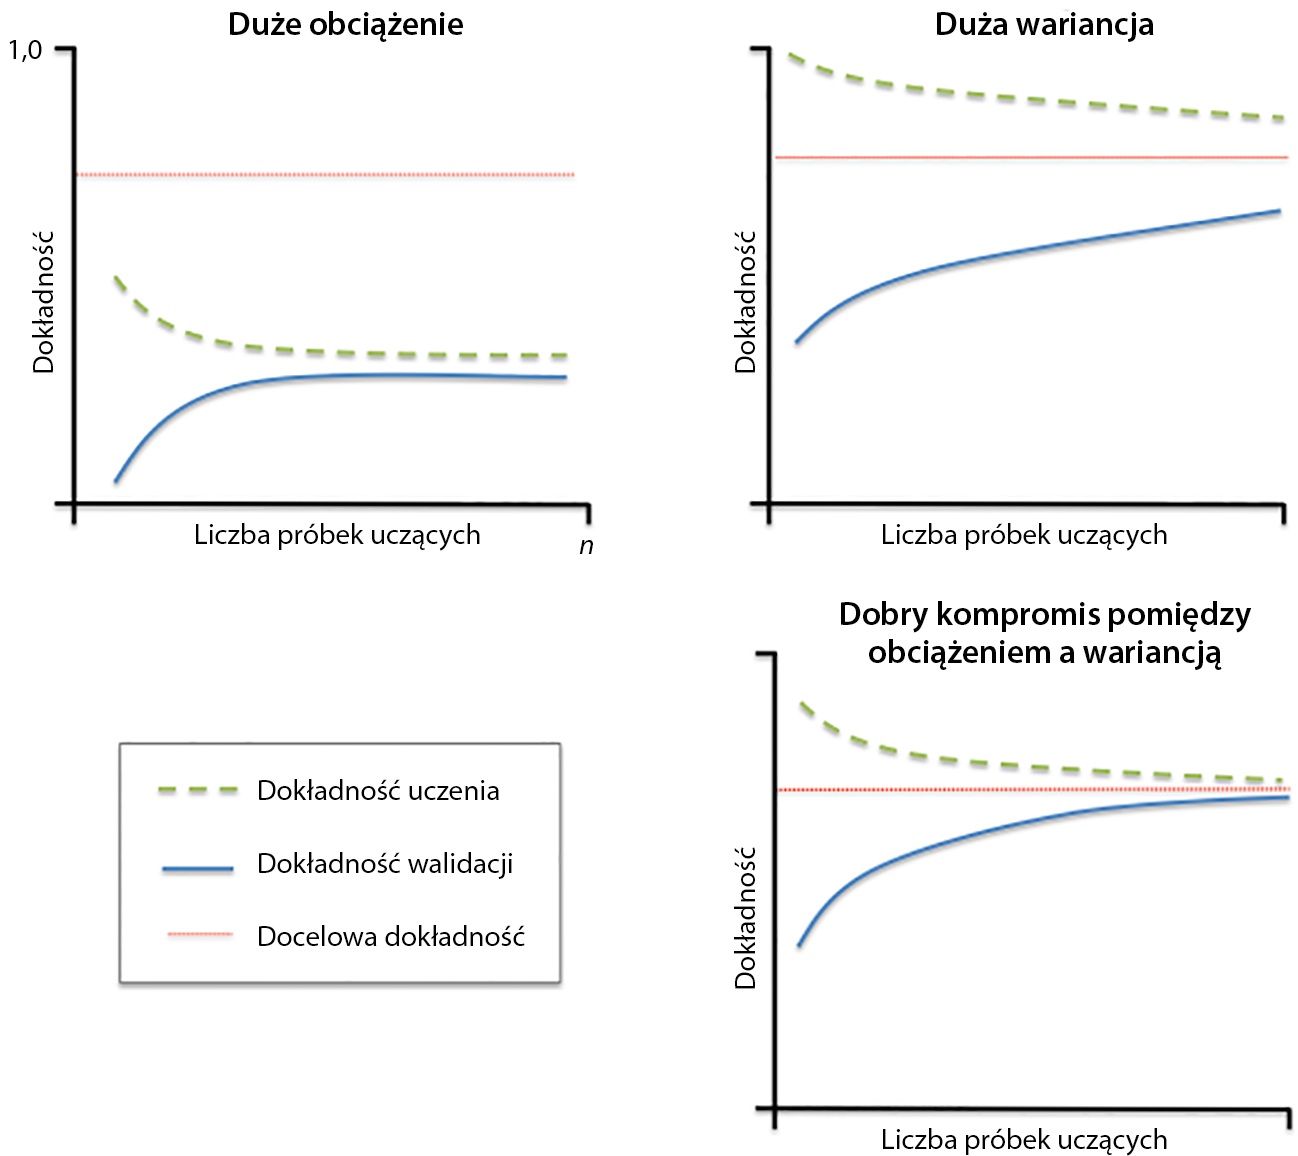

In [13]:
Image(filename='./rysunki/rozdzial 6/06_04.png', width=700)

- pierwszy z  lewej, niskie wartości dokładności uczenia i walidacji, niedostateczne dopasowanie. Rozwiązanie-> zwiększenie liczby parametrów (nowe cechy) oraz zmniejszenie stopnia regularyzacji (w SVM lub regresji logistycznej). 
- Na górze po prawej, duża wariancja, duża przerwa pomiędzy krzywymi dokładności uczenia i walidacji. Eliminacja poprzez zwiększnie liczby próbek lub redukcje złożoności modelu (zwiększenie parametru regularyzacji, zmniejszenie cech przez wybór lub odkrywanie nowych cech. Nie zawsze się uda przy dużym szumie i już wysokiej optymalizacji


Wykorzystanie biblioteki scikit  i funkcji krzywej uczenia do oceny modelu

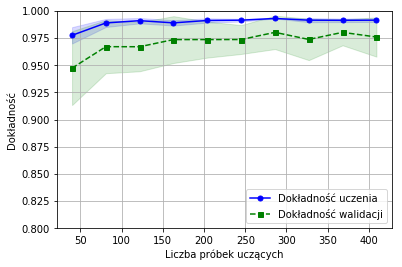

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                train_sizes=np.linspace(0.1, 1.0, 10), 
                cv=10,
                n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Dokładność uczenia')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Dokładność walidacji')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Liczba próbek uczących')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

Model sprawuje się nieźle wobec danych testowych, istnieje jednak możliwość nieznacznego przetrenowania (niewielki odstęp między krzywymi dokładności uczenia i walidacji)

## Rozwiązywanie problemów nadmiernego i niewystarczającego dopasowania za pomocą krzywych walidacji 

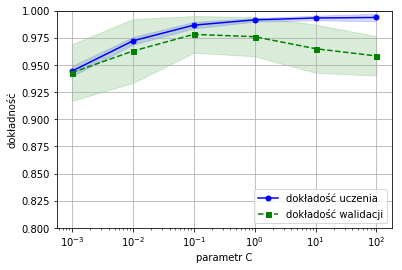

In [15]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__C',
    param_range=param_range,
    cv=10)
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)
plt.plot(param_range,train_mean, color='blue',marker='o',markersize=5,label='dokładość uczenia')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15, color='blue')
plt.plot(param_range,test_mean, color='green',linestyle='--',marker='s',markersize=5,label='dokładość walidacji')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('parametr C')
plt.ylabel('dokładność')
plt.ylim([0.8, 1.0])
plt.show()

Wykorzystaliśmy parametr C do krzywych walidacji, czyli odwrotność parametru regularyzacji przy regresji logistycznej ('clf__C' przy param name). Następnie wygenerowano wykres uśrednionych krzywych(wykorzystano k-krotny sprawdzian krzyżowy) dokładności uczenia i walidacji wraz z odchyleniami.
Co można zauważyć, przy zwiększonej regularyzacji (mniejsze C) może brakować nieco dopasowania, jednak przy dużych C, widzimy delikatne przetrenowanie, optymalne C to według rysunku 0.1.

## Dostrajanie modeli uczenia maszynowego za pomocą metody przeszukiwania siatki 

- lista wartości różnych parametrów, komputer ocenia skuteczność dla każdej kombinacji:

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc= Pipeline([('scl',StandardScaler()),
                   ('clf', SVC(random_state=1))])
param_range=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid=[{'clf__C':param_range,
            'clf__kernel':['linear']},
           {'clf__C':param_range,
           'clf__gamma':param_range,
           'clf__kernel':['rbf']}]
gs=GridSearchCV(estimator=pipe_svc,
               param_grid=param_grid,
               scoring='accuracy',
               cv=10,
               n_jobs=-1)
gs =gs.fit(X_train,y_train)

In [17]:
print(gs.best_score_)

0.978021978021978


In [18]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


Za pomocą gridSearchCV wyuczyliśmy i dostroiliśmy maszynę wektorów nośnych. Do parametru  param_grid przydzieliliśmy listę słowników zawierających hiperparametry do strojenia.Dla liniowej maszyny SVM ocenialiśmy jedynie parametr C (regularyzacja), w przypadku f. jądra dodatkowo parametr gamma. Best_score_ podaje najlepszy wynik a atrybuty w best_params_. Następnie sprawdzamy za pomocą danych testowych nasz model

In [19]:
clf=gs.best_estimator_
clf.fit(X_train,y_train)
print('Dokładnośćtestu: %.3f' % clf.score(X_test,y_test))

Dokładnośćtestu: 0.965


!!!! poszukać informacji o module RandomizedSearchCV w sciki-learn

##  Dobór algorytmu poprzez zagniedżony sprawdzian krzyżowy

- Przy dobieraniu algorytmu warto korzystać z zagnieżdżonego sprawzianu krzyżowego (nested cross-validation). 
- w artkule (link w ksiązce str. 193) opisano, iż prawdziwy błąd szacowania niemal wcale nie jest obarczony obciązeniem pochodzenie z zestawu testowego
- mamy do czynienia z zewnętrzną petlą k-krotnego sprawdzianu krzyżowego wobec podzbioru uczącego. Po wybraniu modelu jest sprawdzona jego skuteczność wobec danych testowych
- na rysunku poniżej koncepcja __kroswalidacji 5x2__

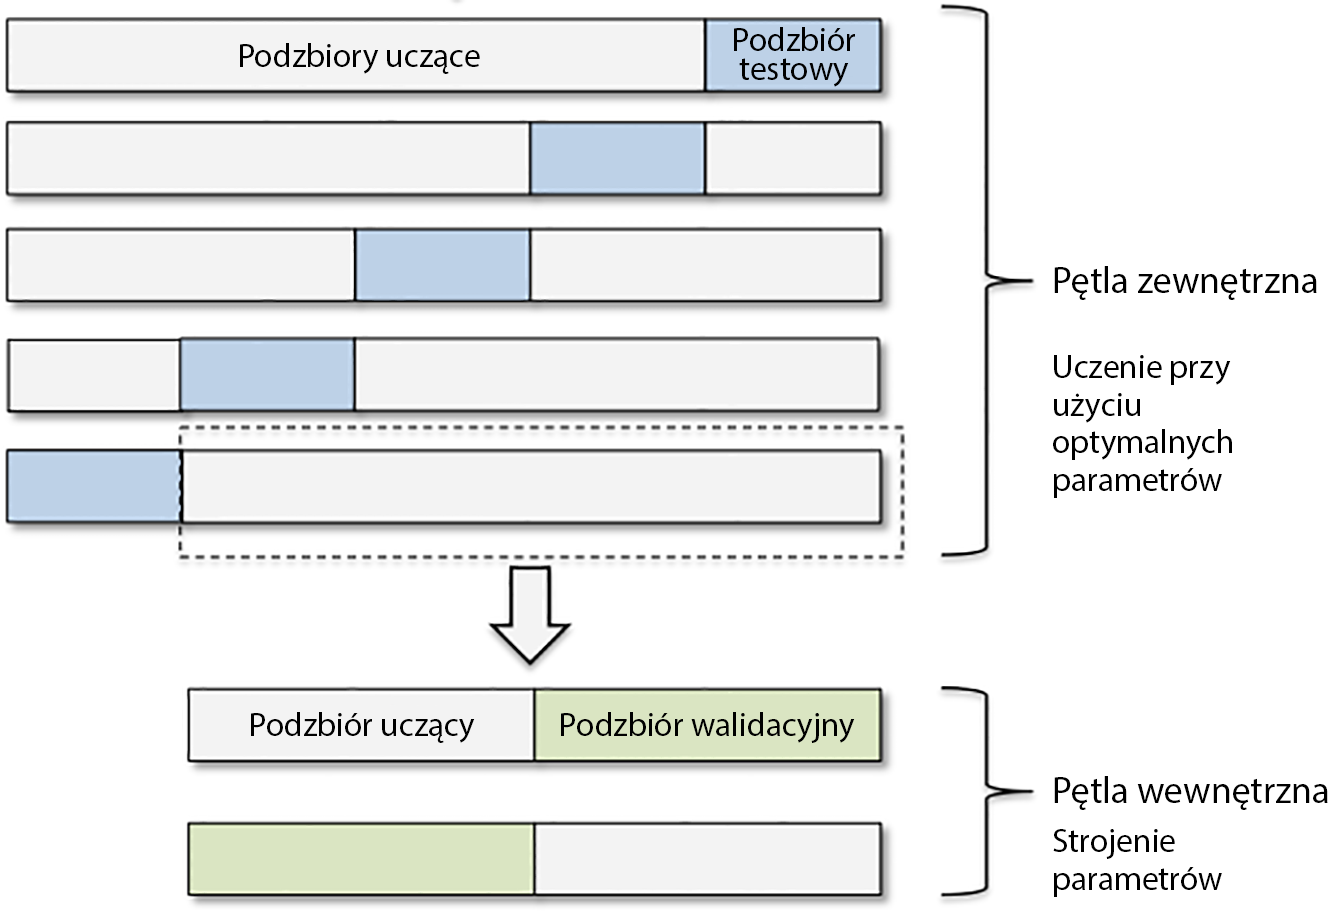

In [20]:
Image(filename='./rysunki/rozdzial 6/06_07.png', width=600)

In [21]:
gs=GridSearchCV(estimator=pipe_svc,
               param_grid=param_grid,
               scoring='accuracy',
               cv=2,
               n_jobs=-1)
scores=cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print('Dokładność sprawdzianu krzyżowego: %.3f +/- %.3f'% (np.mean(scores),np.std(scores)))

Dokładność sprawdzianu krzyżowego: 0.965 +/- 0.025


Porównanie z prostym algorytem drzewa decyzjnego

In [22]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{
        'max_depth': [1, 2, 3, 4, 5, 6, 7, None]
    }],
    scoring='accuracy',
    cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy',cv=5)
print('Dokładność sprawdzianu krzyżowego: %.3f +/- %.3f'% (np.mean(scores),np.std(scores)))

Dokładność sprawdzianu krzyżowego: 0.921 +/- 0.029


Jak widać po sprawdzianie skuteczność modelu SVM jest o wiele wyższa. 

##  Przegląd metryk oceny skuteczności

- kilka rodzajów metryk skuteczności: wyniki precyzji, pełności i parametru F1

## Odczytywanie macierzy pomyłek (confusion matrix)

- tabela pozwalająca określenie skuteczności algorytmu
- macierz kwadratowa z wyniki przewidywań klas: prawdzinie pozytywna, faszływie pozytywna, prawdziwie negatywna, fałszywie negatywna

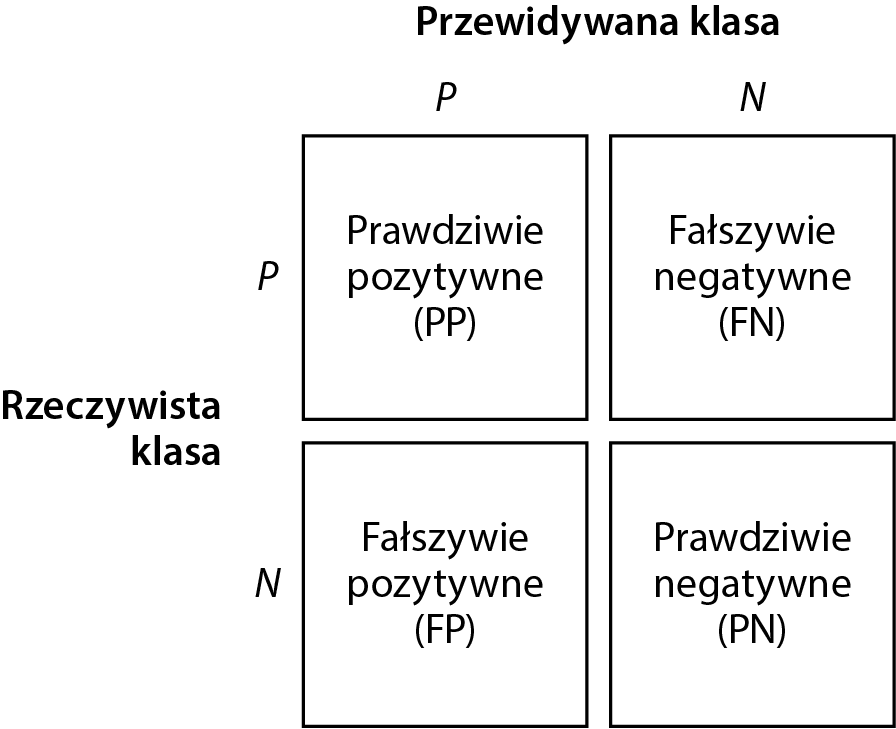

In [23]:
Image(filename='./rysunki/rozdzial 6/06_08.png', width=400)

In [24]:
from sklearn.metrics import  confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred= pipe_svc.predict(X_test)
confmat= confusion_matrix(y_true=y_test, y_pred=y_pred,labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


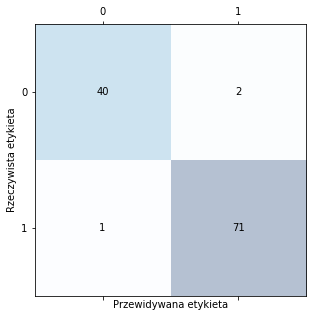

In [25]:
fig, ax= plt.subplots(figsize=(5,5))
ax.matshow(confmat,cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i, s=confmat[i,j],va='center',ha='center')
plt.xlabel('Przewidywana etykieta')
plt.ylabel('Rzeczywista etykieta')
plt.show()

## Optymalizacja precyzji i pełności modelu klasyfikującego 

- zarówno błąd (BŁĄD) jak i dokładność (DOK) przewidywań dostarczają info na temat liczby nieprawidłowo sklasyfikowanych próbek.
$$BŁĄD =\frac{FP +FN}{FP+FN+PP+PN}$$
$$DOK =\frac{PP +PN}{FP+FN+PP+PN}=1-BŁĄD$$


- odsetek prawdziwie pozytywnych (OPP true positive rate) o odsetek fałszywie pozytywnych(OFP) są użyteczne przy niezrównoważonych klasach
$$OFP=\frac{FP}{N}=\frac{FP}{FP+PN}$$
$$OFP=\frac{PP}{P}=\frac{PP}{PP+FN}$$


Prezycja (PRE, precision) i pełność (PEŁ, recall) to metryki powiązane z odsetkiem prawdziwie pozytywnych i prawdziwie negatywnych
$$PRE=\frac{PP}{PP+FP}$$
$$PEŁ=OPP=\frac{PP}{FN+PP}$$

W praktyce często korzystamy z kombinacji precyzji i pełności tj. wyniku F1.
$$F1=2\frac{PRE\times PEŁ}{PRE+PEŁ}$$

In [26]:
from sklearn.metrics import precision_score, recall_score,f1_score
print('Precyzja: %.3f'% precision_score(y_true=y_test, y_pred=y_pred))

Precyzja: 0.976


In [27]:
print('Pełność: %.3f'% recall_score(y_true=y_test, y_pred=y_pred))

Pełność: 0.952


In [28]:
print('F1: %.3f'% f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.964


Definiując scoring inaczej w GridSearchCV mamy inne metryki skuteczności

## Wykres krzywej ROC 

Wykres krzywej charakterystki roboczej (receiver operating characteristic)  to b dobre narzędzie doboru modelu klasufikującego, skuteczność obliczona na podstawie fałszywie pozytywnych i prawdziwie pozytywnych, które wyliczamy poprzez przesunięcie progu decyzjnego klasyfikatora.
Przekątną krzywej ROC możemy interpretować jako losowe zgadywanie, a skuteczność modeli klasyf. znajdujących się pod obszarem  tek przkątnej jest uznawana za gorszą od zgadywania.  Idealny klasyf. znajdowałby sięw lewym górnym rogu wykresu (opp 1 ofp=0). Na podstawie tej krzywej możemy wyliczyć __obszar pod krzywą__ ROC (area under curve AUC) opisujący skuteczność modelu.

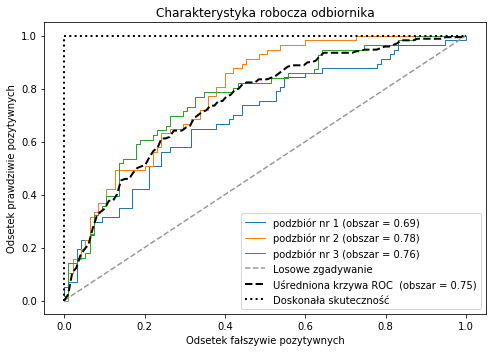

In [43]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)), 
                    ('clf',LogisticRegression(penalty='l2',random_state=0,C=100.0))])
X_train2 = X_train[:, [4, 14]]
#wybieramy tylko 2 cechy z zestawu danych
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate (cv):
    probas=pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, threshold = roc_curve(y_train[test], probas[:,1],pos_label=1)
    mean_tpr+=interp(mean_fpr, fpr, tpr)
    mean_tpr[0]= 0.0
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,lw=1, label= 'podzbiór nr %d (obszar = %0.2f)' %(i+1, roc_auc))
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='Losowe zgadywanie')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Uśredniona krzywa ROC  (obszar = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], 
         [0, 1, 1], 
         lw=2, 
         linestyle=':', 
         color='black', 
         label='Doskonała skuteczność')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Charakterystyka robocza odbiornika')
plt.legend(loc="lower right")

plt.tight_layout()
#plt.savefig('./rysunki/06_10.png', dpi=300)
plt.show()

Omówienie:
- zastosowano klasę StratifiedKfold i oddzielnie dla każdej iteracji podzbiorów obliczyliśmy krzywą ROC klasyfikatora LogisticRegression przy użyciu roc_curve.
- dokonano interpolacji uśrednionej krzywej roc z 3 podzbiorów za pomocąfunkcji interp.  
- można zauważyć, że istnieje rozbieżoność wariancji pomiędzy 3 zbiorami, a uśredniona wartość ROC (0.75) mieści się między wartością idealną algorytmu a losowym zgadywaniem (0.5)
- jeśli interesuje nas tylko wynik AUC:

In [45]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])
from sklearn.metrics import roc_auc_score, accuracy_score
print('Obszar pod krzywą ROC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Dokładność: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

Obszar pod krzywą ROC: 0.662
Dokładność: 0.711


Sorawdzenie skuteczności klasyfikatora oprzy pomocy ROC pozwala obserwować skuteczność wobec niezrównoważonych próek. Wyniki dokładności możemy interpretować jako pojedynczy punkt graniczny krzywej ROC, ale udowodniono, że obszar pod krzywą ROC i metryka dokładności zazwyczaj dają zbliżone wyniki

## Metryki zliczające dla klasyfikacji wielkoklasowej


- poprzednie metryki zliczające charakterystyczne dla systemów klasyf. binarnej
- scikit-learn zawiera metody __makro i mikrouśrednia__ pozwlające na stosowanie tych metryk w problemach wieloklasowych poprzez klasyfikację jeden przeciw wszystkim
- uśrednianie mikroskopowe poelga na zliczaniu średniej każdej prognozy(pp,pn,fp,fn) w systemie. Przykładowo w k-klasowym wartość mikro średniej precyzji:
$$PRE_{mikro}= \frac{PP_1+...+PP_k}{PP_1+...+PP_k+FP_1+...+FP_k}$$
- wartość makro średniej to uśredniona wartość sumy precyzji wszystkich systemów:
$$PRE_{makro}= \frac{PRE_1+...+PRE_k}{k}$$
- mikroskopowe uśrednianie pożyteczne gdy chemy w  taki sam sposób ważych każdą instacje/prognozę, makro gdy ogólnie wyliczamy skuteczność klasyfikatora pod względem najczęsciej wystepujących etykiet
- przy użyciu binarnych metryk skuteczności interfejsu scikit do oceny wieloklasowej domyślnie stosowany jest wariant znormalizowej lub ważonej średniej makroskopwej. Makroskopowa średnia ważona wyliczana poprzez ważenie wyników każdej etykiety przez liczbę prawdziwych wystąpień.  (przydaje się przy niezrównoważonych klasach
- inne metody uśredniania wybieramy przy tworzeniu własnej metryki:

In [47]:
from sklearn.metrics import make_scorer
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')